In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sys
sys.path.append("../scripts")
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning


pressure=1
diffusion="nodiff"

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_EFilt_smear_1.h5", "MC/hits")

# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_1.h5", "MC/hits")

# hits = pd.read_hdf("../data/Trackreco/ATPC_Tl_1bar_nodiff_reco.h5", "data")


# hits = pd.read_hdf("../data/test/test.h5", "MC/hits")

display(hits)
event_list = hits.event_id.unique()
print(event_list)


,event_id,x,y,z,energy
0,244,-146.169281,2633.830811,1455.0,0.010311
1,244,-146.169281,2638.830811,1455.0,0.011412
2,244,-141.169281,2633.830811,1455.0,0.001251
3,244,-151.169281,2638.830811,1460.0,0.003103
4,244,-151.169281,2643.830811,1460.0,0.002728
...,...,...,...,...,...
50921,309,883.830750,1733.830688,4525.0,0.000325
50922,309,888.830750,1733.830688,4525.0,0.000826
50923,309,888.830750,1738.830688,4525.0,0.001576
50924,309,888.830750,1743.830688,4525.0,0.002227


[244 245 246 247 248 249 250 251 252 253 254 255 256 258 259 260 261 263
 264 265 266 267 268 269 271 272 273 274 275 277 278 279 280 281 282 283
 284 285 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309]


,event_id,x,y,z,energy
0,244,-146.169281,2633.830811,1455.0,0.010311
1,244,-146.169281,2638.830811,1455.0,0.011412
2,244,-141.169281,2633.830811,1455.0,0.001251
3,244,-151.169281,2638.830811,1460.0,0.003103
4,244,-151.169281,2643.830811,1460.0,0.002728
...,...,...,...,...,...
781,244,-556.169250,2638.830811,2545.0,0.011011
782,244,-556.169250,2643.830811,2545.0,0.003704
783,244,-566.169250,2648.830811,2550.0,0.001627
784,244,-566.169250,2653.830811,2550.0,0.043645


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.3 keV
diffision scale factor is:  7
Radius scale factor is:  10
Hit grouping factor is:  10
Tortuosity distance scale is: 70.0
The voxel size is: 5.0
The det half_length is:  3091.169274839764
mean_sigma: 10


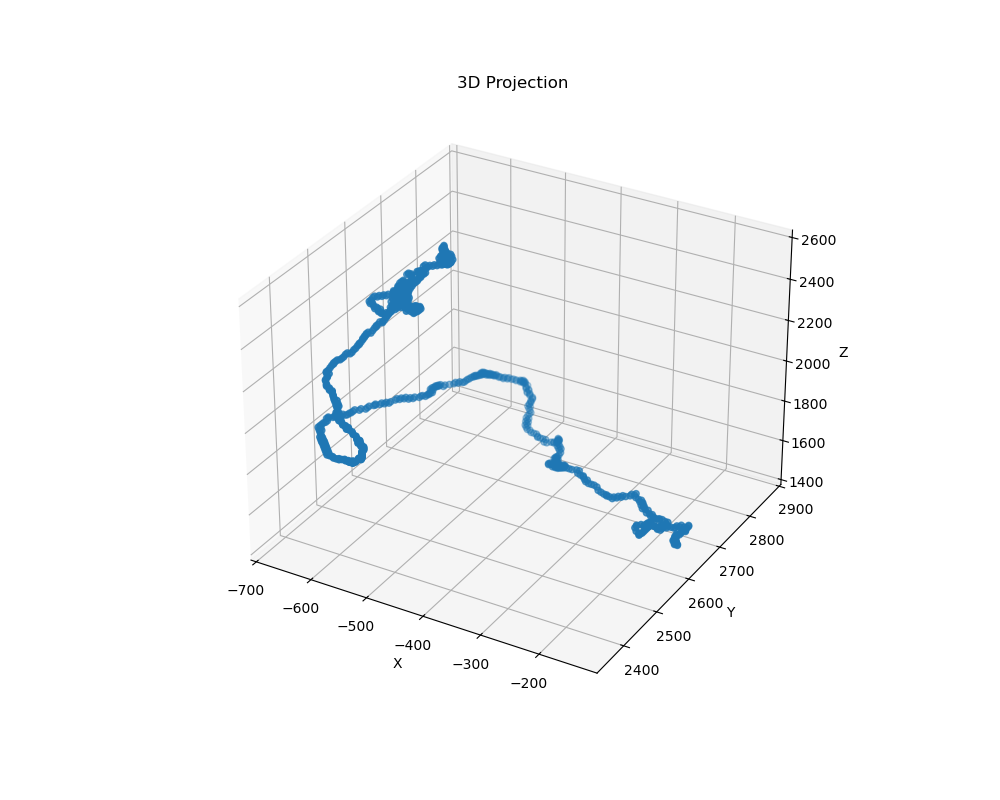

In [20]:
%matplotlib widget

data = hits[hits.event_id ==event_list[0]]
# data = hits[hits.event_id ==395909]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]


# Apply grouping
Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_half_length = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)
print("The voxel size is:",           voxel_size)
print("The det half_length is: ",     det_half_length)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

reco_DE_event = data.copy()

mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())

if (mean_sigma_group < 1.5*voxel_size):
    mean_sigma_group = 1.5*voxel_size

data = GroupHits(reco_DE_event, mean_sigma_group)

# Apply energy threshold and redistribute energy
data = CutandRedistibuteEnergy(data, energy_threshold)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(data.group_id.unique()):
    temp_df = data[data.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='o')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



,event_id,x,y,z,energy,group_id
0,244,-671.169250,2478.830811,1875.0,0.003328,0
1,244,-671.169250,2483.830811,1870.0,0.000551,0
2,244,-671.169250,2483.830811,1875.0,0.000826,0
3,244,-666.169250,2448.830811,1880.0,0.000776,0
4,244,-666.169250,2453.830811,1880.0,0.002453,0
...,...,...,...,...,...,...
781,244,-141.169281,2658.830811,1490.0,0.002753,0
782,244,-141.169281,2658.830811,1495.0,0.003128,0
783,244,-141.169281,2663.830811,1495.0,0.004304,0
784,244,-141.169281,2668.830811,1495.0,0.005506,0


Median distance to the closest row: 5.0


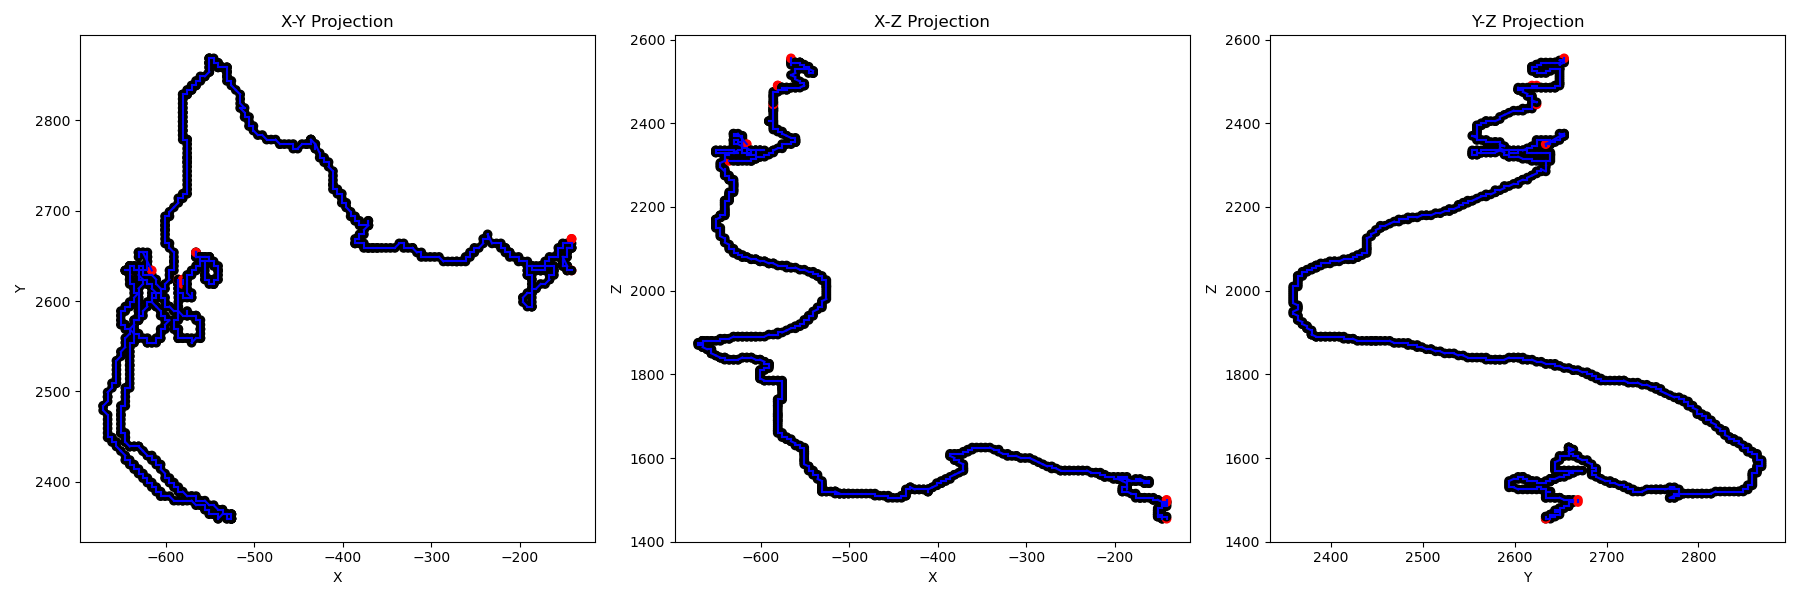

In [21]:




# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
Meadian_dist = GetMedianNodeDistances(data) # Median distance between nodes
init_dist_thresh = Meadian_dist*2 # max distance for initial connections [mm]
incr_dist_thresh = np.linspace(1, Meadian_dist*7, 15, dtype=int) # Second stage, look for closest nodes, then slowly increase threshold [mm]
incr_dist_thresh = np.unique(incr_dist_thresh)

dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection, the connection is within the dist threshold and is within the same group
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh and CheckSameGroup(data, i, closest_idx)):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is <=1, also that the proposed node is in the same group
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []) and CheckSameGroup(data, i, closest_idx): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

/var/folders/cf/0fb79lcx5z9by5185swm__x00000gr/T/ipykernel_12004/518107878.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('Dark2')


{'id': 0, 'start': np.int64(121), 'end': np.int64(432), 'nodes': [np.int64(121), np.int64(150), np.int64(171), 170, 190, 214, np.int64(229), 227, 228, np.int64(245), 243, np.int64(241), np.int64(255), 254, np.int64(253), np.int64(272), np.int64(273), np.int64(287), np.int64(288), np.int64(310), np.int64(307), np.int64(311), np.int64(338), np.int64(374), 375, 377, np.int64(376), np.int64(408), np.int64(422), 423, 421, np.int64(445), 444, 442, 443, np.int64(441), np.int64(439), np.int64(440), 420, np.int64(406), np.int64(407), np.int64(372), np.int64(373), np.int64(336), np.int64(337), np.int64(299), np.int64(300), np.int64(301), np.int64(302), np.int64(303), np.int64(304), np.int64(305), np.int64(284), np.int64(285), np.int64(286), 306, np.int64(308), np.int64(309), 312, 313, np.int64(314), np.int64(315), np.int64(316), np.int64(317), np.int64(319), np.int64(322), np.int64(323), np.int64(324), np.int64(325), 330, np.int64(326), np.int64(327), 328, np.int64(320), np.int64(321), np.int64(

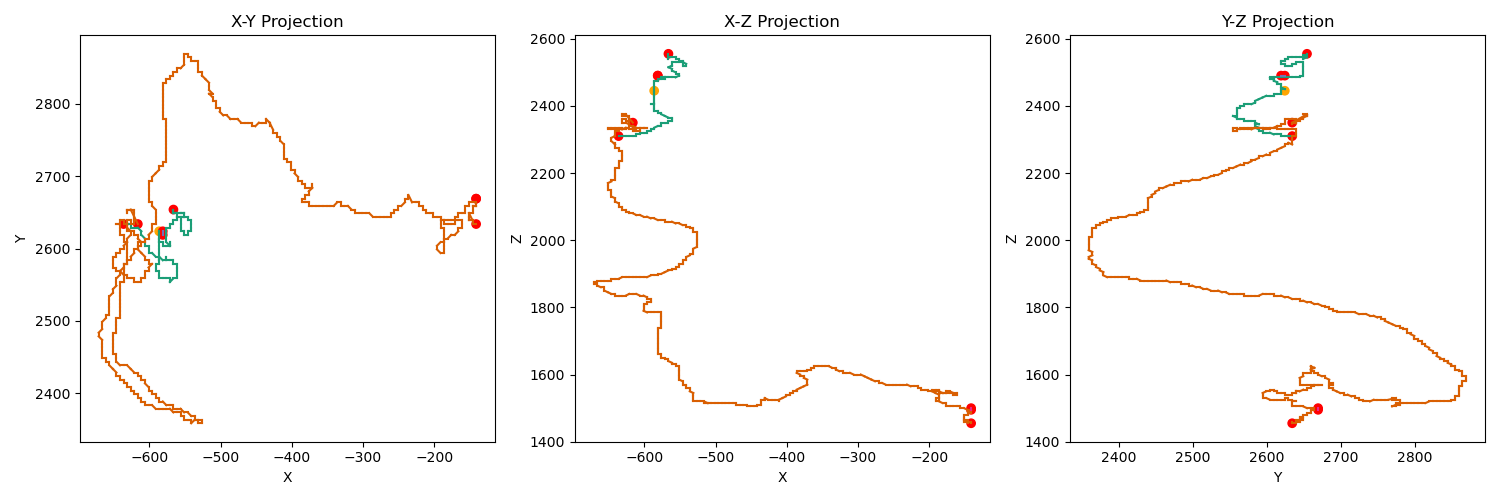

In [22]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]


Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [23]:
print(GetMedianNodeDist(Tracks, data))

dist_threshold = 4*GetMedianNodeDist(Tracks, data)
print("Dist Thresh",dist_threshold)

5.0
Dist Thresh 20.0


In [24]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [25]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
True
Total Tracks: 5
{'id': 2, 'start': np.int64(342), 'end': np.int64(343), 'nodes': [np.int64(342), np.int64(343), np.int64(382)], 'length': np.float64(5.0), 'energy': np.float64(0.0024024818558245897), 'label': 'track', 'c': 'black'}
{'id': 6, 'start': np.int64(784), 'end': np.int64(785), 'nodes': [np.int64(783), np.int64(784), np.int64(785)], 'length': np.float64(5.0), 'energy': np.float64(0.019144777674227953), 'label': 'track', 'c': 'black'}
{'id': 7, 'start': 329, 'end': 329, 'nodes': [329, np.int64(324)], 'length': 0, 'energy': np.float64(0.00050051708240062), 'label': 'gamma', 'c': 'black'}
{'id': 8, 'start': np.int64(95), 'end': np.int64(215), 'nodes': [np.int64(95), np.int64(96), np.int64(97), np.int64(98), np.int64(99), np.int64(123), np.int64(124), np.int64(122), np.int64(151), np.int64(148), np.int64(147), np.int64(167), 166, np.int64(145), np.int64(146), 144, np.int64(116), 115, 88, 87, np.int64(59), np.int64(58), 40, 39, np.int64(38), 37, np.int64(57),

{'id': 0, 'start': np.int64(432), 'end': np.int64(778), 'length': np.float64(3826.749), 'energy': np.float64(2.0169586525007617), 'label': 'Primary', 'c': 'Teal', 'nodes': [np.int64(432), 431, 429, np.int64(430), np.int64(427), np.int64(428), np.int64(454), 448, 466, np.int64(464), np.int64(463), np.int64(462), np.int64(461), np.int64(460), np.int64(478), 477, np.int64(476), np.int64(502), np.int64(501), 500, 504, np.int64(503), np.int64(516), 517, 518, np.int64(519), np.int64(520), np.int64(505), np.int64(506), 480, 483, 469, 453, np.int64(452), 451, np.int64(426), np.int64(450), 449, np.int64(468), 467, np.int64(482), np.int64(481), 479, np.int64(465), 447, np.int64(446), np.int64(425), 424, np.int64(413), np.int64(412), np.int64(383), np.int64(382), 381, 380, 379, np.int64(410), np.int64(411), 409, 378, 339, np.int64(341), np.int64(340), 318, np.int64(321), 320, np.int64(328), np.int64(327), 326, np.int64(330), np.int64(325), 324, 323, 322, 319, 317, 316, 315, 314, np.int64(313), np

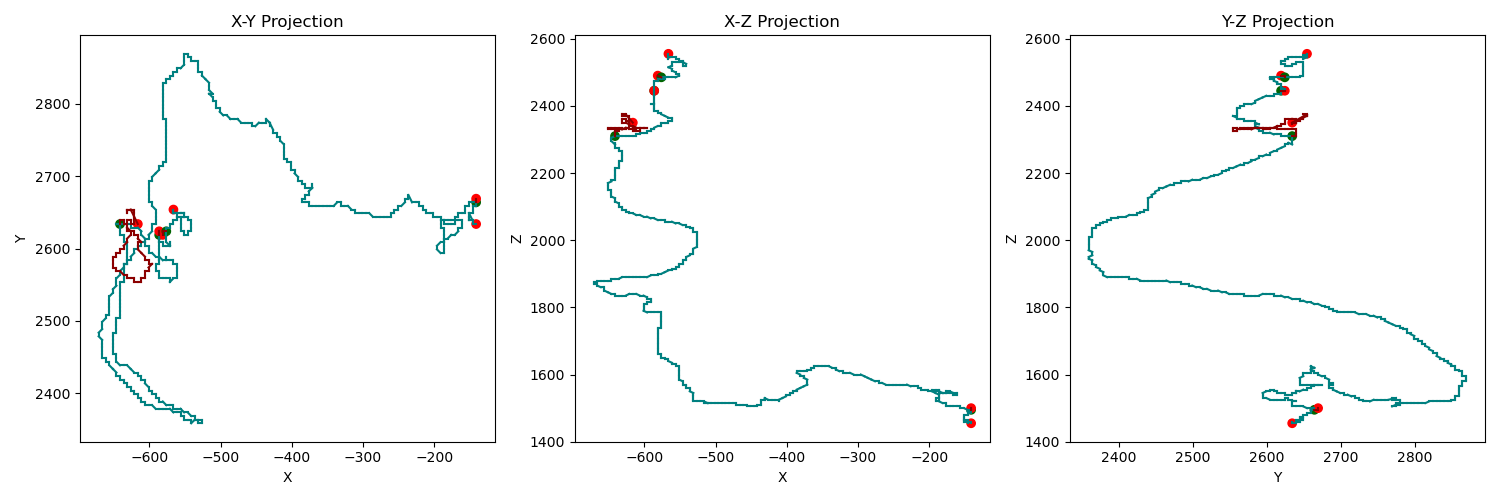

In [26]:


RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

for t in RebuiltTrack:
    print(t)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

# axs[0].scatter(data["x"].iloc[25], data["y"].iloc[25])

plt.tight_layout()
plt.show()



In [27]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in RebuiltTrack:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in RebuiltTrack:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles)

print(connected_nodes)



The primary track is:  0


,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle
0,244,-566.169250,2653.830811,2555.0,0.015416,0,432,1,0,0.000000,0.000000
1,244,-566.169250,2653.830811,2550.0,0.043645,0,431,1,0,5.000000,158.853969
2,244,-566.169250,2648.830811,2550.0,0.001627,0,429,1,0,10.000000,90.000000
3,244,-566.169250,2653.830811,2545.0,0.009960,0,430,1,0,17.071068,135.000000
4,244,-566.169250,2648.830811,2540.0,0.005456,0,427,1,0,24.142136,90.000000
...,...,...,...,...,...,...,...,...,...,...,...
781,244,-586.169250,2623.830811,2445.0,0.000501,0,329,0,2,5.000000,180.000000
782,244,-581.169250,2623.830811,2490.0,0.000576,0,343,0,3,7.071068,144.735610
783,244,-581.169250,2618.830811,2490.0,0.001827,0,342,0,3,12.071068,90.000000
784,244,-141.169281,2668.830811,1495.0,0.005506,0,784,0,4,5.000000,135.000000


{0: [np.int64(2), np.int64(8)], np.int64(2): [0, 1], 1: [np.int64(2), np.int64(9)], 3: [np.int64(4), 14], np.int64(4): [3, 5], 5: [np.int64(4), 6], 6: [np.int64(5), np.int64(7)], 7: [np.int64(8), np.int64(6)], np.int64(8): [7, np.int64(0)], 9: [np.int64(11), np.int64(1)], np.int64(11): [9, np.int64(10)], 10: [np.int64(12), 11], np.int64(12): [10, np.int64(15)], 13: [np.int64(18), np.int64(14)], np.int64(18): [13, 17], 14: [np.int64(3), np.int64(13)], 15: [np.int64(16), np.int64(12)], np.int64(16): [15, np.int64(19)], np.int64(19): [16, np.int64(20)], 17: [np.int64(18), 25], 20: [np.int64(21), np.int64(19)], np.int64(21): [20, np.int64(22)], 22: [np.int64(23), np.int64(21)], np.int64(23): [22, np.int64(24)], np.int64(24): [23, np.int64(35)], 25: [np.int64(17), np.int64(42)], 26: [np.int64(27), 47], np.int64(27): [26, np.int64(28)], np.int64(28): [27, np.int64(29)], 29: [np.int64(30), np.int64(28)], np.int64(30): [29, np.int64(31)], np.int64(31): [30, np.int64(32)], np.int64(32): [31, np

Text(0, 0.5, 'Scatter Angle [deg]')

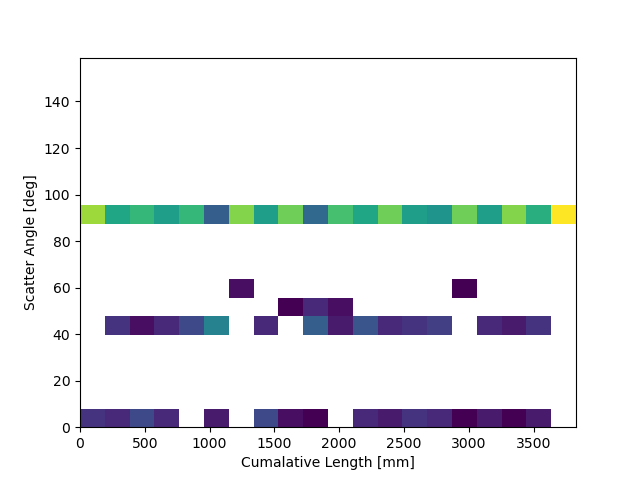

In [28]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

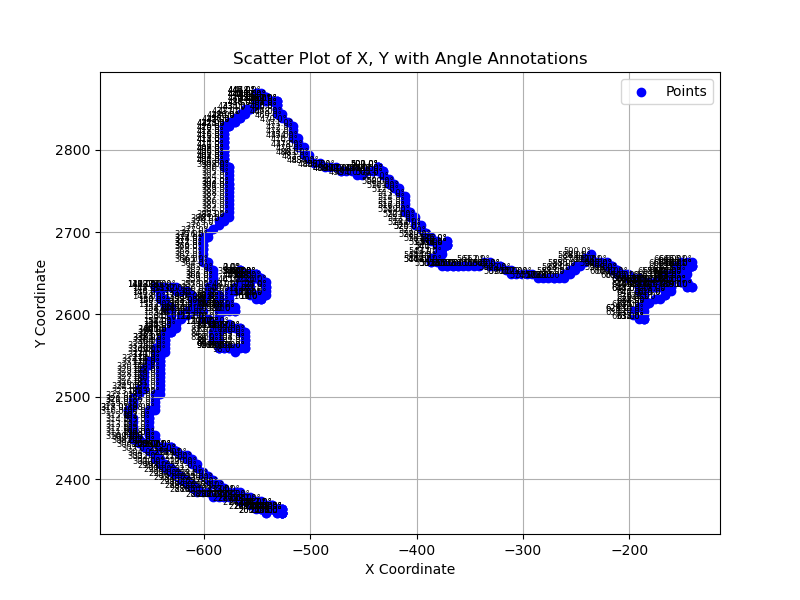

In [29]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [30]:
# Calculate Track Tortuosity

df_angles = CalcAngularVars(df_angles, Tortuosity_dist)

In [31]:
display(df_angles)

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
0,244,-566.169250,2653.830811,2555.0,0.015416,0,432,1,0,0.000000,0.000000,1.975490,1.358646
1,244,-566.169250,2653.830811,2550.0,0.043645,0,431,1,0,5.000000,158.853969,2.017893,1.335978
2,244,-566.169250,2648.830811,2550.0,0.001627,0,429,1,0,10.000000,90.000000,2.026622,1.373915
3,244,-566.169250,2653.830811,2545.0,0.009960,0,430,1,0,17.071068,135.000000,1.956265,1.301557
4,244,-566.169250,2648.830811,2540.0,0.005456,0,427,1,0,24.142136,90.000000,1.984690,1.374308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,244,-586.169250,2623.830811,2445.0,0.000501,0,329,0,2,5.000000,180.000000,1.000000,0.000000
782,244,-581.169250,2623.830811,2490.0,0.000576,0,343,0,3,7.071068,144.735610,1.000000,0.000000
783,244,-581.169250,2618.830811,2490.0,0.001827,0,342,0,3,12.071068,90.000000,1.000000,0.000000
784,244,-141.169281,2668.830811,1495.0,0.005506,0,784,0,4,5.000000,135.000000,1.000000,0.000000


Text(0, 0.5, 'Angle [deg]')

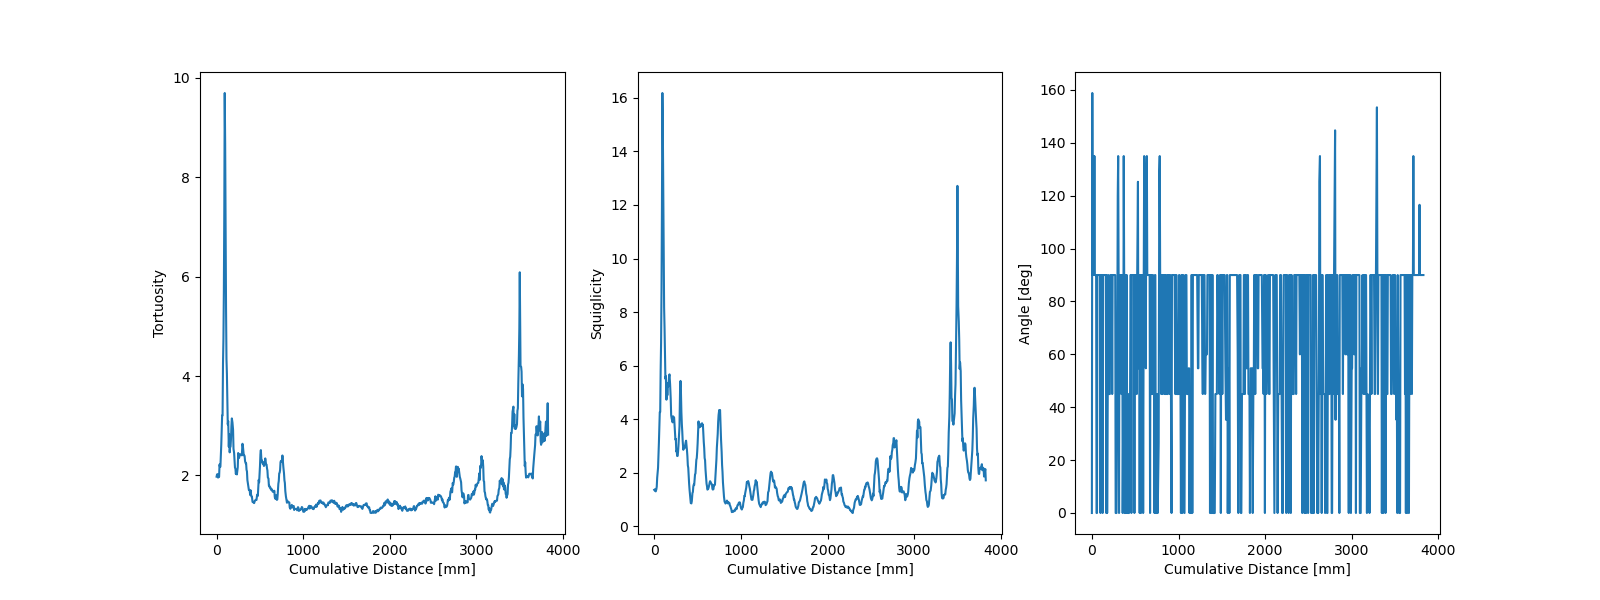

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Tortuosity"])
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Squiglicity"])
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["angle"])
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle [deg]")

In [33]:
Track_df = GetTrackdf(df_angles, RebuiltTrack, 500, 180, 200, 1) # scale these params inversely with the pressure

display(Track_df)

print(Track_df.energy.sum())



,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,244,0,1,432,778,3826.749,2.016959,0.405394,0.400213,0.39671,0.444059,3.525740,2.708100,5.504482,2.664348,Primary
0,244,1,0,95,215,502.054,0.420434,0.419133,0.420434,0.00000,0.420434,1.837435,3.450799,1.964242,2.801605,Delta0
0,244,2,0,324,329,5.000,0.000501,0.000501,0.000501,0.00000,0.000501,0.000000,0.000000,0.000000,0.000000,Delta0
0,244,3,0,382,342,12.071,0.002402,0.002402,0.002402,0.00000,0.002402,1.000000,1.000000,0.000000,0.000000,Delta0
0,244,4,0,783,785,10.000,0.019145,0.019145,0.019145,0.00000,0.019145,1.000000,1.000000,0.000000,0.000000,Delta0


2.4594407677359413


In [34]:

Track_df_u = UpdateTrackMeta(Track_df, df_angles, 100)

display(Track_df_u)


Adding Delta0 energy to blob1 as dist was 76.81145477294922
Adding trk 4 Delta0 energy to blob2 as dist was 50.0
Swapping the blob names


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,244,0,1,778,432,3826.749,2.016959,0.419358,0.407796,0.463203,0.399112,3.708100,4.525740,2.664348,5.504482,Primary
0,244,1,0,95,215,502.054,0.420434,0.419133,0.420434,0.000000,0.420434,1.837435,3.450799,1.964242,2.801605,Delta0
0,244,2,0,324,329,5.000,0.000501,0.000501,0.000501,0.000000,0.000501,0.000000,0.000000,0.000000,0.000000,Delta0
0,244,3,0,382,342,12.071,0.002402,0.002402,0.002402,0.000000,0.002402,1.000000,1.000000,0.000000,0.000000,Delta0
0,244,4,0,783,785,10.000,0.019145,0.019145,0.019145,0.000000,0.019145,1.000000,1.000000,0.000000,0.000000,Delta0
